In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src/')
import wave_mut_rate_newton as wNwt
import wave_mut_rate as wD
import wave as w
import numba_functions as nbf
import utils as ut
import plotter
import numba_functions as nbf
import numba as nb
from copy import deepcopy
from scipy.optimize import brentq
import pickle
import os

In [3]:
def build_assay_wave_newton(id_, time, D_CFL, r0, lr, dx, n_x_bins, t_burn_cutoff, t_burn,
                            nwt_step=500, Nh=1e10, Ud=0.1, Ub_guess=1e-4, dx2=1, init_n=None, init_nh=None):
    """
    Building an object that finds the value of D given the speed of the wave (subs_rate).
    It starts form an initial Ub guess and uses a newton method.
    """
    dt = ut.dt_from_cfl(0.03, D_CFL, dx)
    nwt_pars = wNwt.Newton_pars(learn_rate=lr, t_newton=time, t_newton_step=nwt_step, t_speed=nwt_step/3)
    
    p = wNwt.Vwave_newton_mut_rate_pars(id_, dx=dx, dt=dt, n_x_bins=n_x_bins,
                t_burn_cutoff=t_burn_cutoff, t_burn=t_burn, newton_pars=nwt_pars,
                r0=r0, M=5, R0=1.8, recovery=0.2, subs_rate=2.6/365, 
                Ud=Ud, Ub_guess=Ub_guess, Nh=Nh, N0=Nh/100, dx2=dx2,
                cutoff=1, global_cutoff=True, 
                back_width_fract=ut.lin_from_two_points(np.log(r0), np.log(0.1), 0.01, np.log(5), 3),
                traj_step=int(20/dt), check_step=int(0/dt), traj_after_burn=False, verbose=True)
    
    return deepcopy(wNwt.Vwave_newton_mut_rate(p, init_n=init_n, init_nh=init_nh))


def build_assay_wave_es(id_, time, Ds, r0, eps, lambda_tilde, dx, n_x_bins, t_burn_cutoff, t_burn, Nh=1e10, 
                        dx2=1, D_CFL=None, init_n=None, init_nh=None):
    """
    Building an object that finds the evolutionary stable value of D
    """
    if D_CFL==None:
        dt = ut.dt_from_cfl(0.03, Ds[int(np.round(len(Ds)/2))], dx)
    else:
        dt = ut.dt_from_cfl(0.03, D_CFL, dx)

    p = wD.Vwave_mut_rate_pars(id_, tot_time=time, dt=dt, dx=dx, n_x_bins=n_x_bins, 
                     M=5, r0=r0, alpha=0, beta=1.8*0.2, gamma=0.2, lambda_tilde=lambda_tilde,
                     eps=eps, Ds=Ds,
                     Nh=Nh, N0=Nh/10, cutoff=1,
                     t_burn_cutoff=t_burn_cutoff, t_burn=t_burn, 
                     back_width_fract=ut.lin_from_two_points(np.log(r0), np.log(0.1), 0.01, np.log(5), 3),
                     traj_step=int(5/dt), check_step=int(0/dt), traj_after_burn=False, verbose=True, global_cutoff=True)
    
    return deepcopy(wD.Vwave_mut_rate(p, False, init_n=init_n, init_nh=init_nh))

def estf(d):
    k = -2.3381 * (d*s**2)**(1/3)
    return f*(1 - 2*l*d) + 2*k*(2/3 - l*d) - a*l*d

class eps_schedule():
    """
    Scheduling of the diffusion on the mutation of the evolutionary stability parameter
    """
    def __init__(self, first_eps, first_time, decay_exp, decay_scale):
        self.first_eps = first_eps
        self.first_time = first_time
        self.decay_exp = decay_exp
        self.decay_scale = decay_scale
        
    def get(self, t):
        if t < self.first_time:
            return self.first_eps
        else:
            t1 = t - self.first_time
            return self.first_eps*( self.decay_scale/(t1 + self.decay_scale) )**self.decay_exp

In [3]:
def plot_D_newton(ax, w, fontsize=12):
    ax.set_xlabel('time', fontsize=fontsize)
    ax.set_ylabel(r'$D$', fontsize=fontsize)
    ax.set_title('r0=%g, final $D$=%g'%(w.p.r0, w.p.D_coef), fontsize=fontsize)
    ax.plot(w.traj.times, w.traj.D, lw=2)
    ax.axvline(x=w.p.t_burn, linestyle = ':', color = 'k')
    return ax

def plot_loss_newton(ax, w, dt=30, fontsize=12):
    ax.set_xlabel('time', fontsize=fontsize)
    ax.set_ylabel(r'$v/\sqrt{\langle dx^2 \rangle} - n_{subs}$', fontsize=fontsize)
    ax.set_title('lr=%g, nwt step=%g, '%(w.p.nwt.lr, w.p.nwt.t_step), fontsize=fontsize)
    ax.plot(w.traj.times[dt:], w.traj.speed(dt)/np.sqrt(w.p.dx2)-w.p.subs, lw=2)
    ax.plot(w.traj.times, np.zeros(len(w.traj.times)), ls='--', color='k', lw=2)
    ax.axvline(x=w.p.t_burn, linestyle = ':', color = 'k')
    return ax

def plot_wave(ax1, ax2, w, fontsize=12):
    ax1, ax11 = plotter.plot_populations(ax1, w)
    ax1.set_xlim(0, w.p.n_x_bins*w.p.dx)
    try:
        ax2, ax22 = plotter.plot_fitness(ax2, w)
        ax2.set_title('dx=%g, n x bins=%g'%(w.p.dx, w.p.n_x_bins), fontsize=fontsize)
    except ValueError:
        pass
    ax11.set_yscale('log')
    return ax1, ax2

def plot_D_es(ax, we, fontsize=12):
    ax.set_ylabel('$D_{ES}$', fontsize=fontsize)
    ax.plot(we.traj.times, we.traj.mean_D)
    std = we.traj.std_D
    ax.fill_between(we.traj.times, we.traj.mean_D-std, we.traj.mean_D+std, alpha=0.5)
    ax.set_title('eps0=%g'%(we.p.eps.get(0)), fontsize=fontsize)
    plt.tight_layout()
    return ax

## r0 scan
The cross reactivity is varied using a newton-like method such that the diffusion coefficient constrained by the speed and the evolutionary stable one coincide

In [4]:
def newton_and_es_step(r0, time_nwt, D_guess, init_n, init_nh, dx, n_x_bins, n_D_bins=51, nwt_step=2000, lr=2.5e-5, 
                       Ud=0.1, Nh=10**10, time_es=10000, eps=1e-13):
    """
    It performs a newton step finding D constrained by a given speed. From this D a lambda is computed and 
    used in the ES evaluation, which leads to a second, possibily different D.
    """
    wave_nwt = build_assay_wave_newton(0, time_nwt, D_guess, r0, lr, dx, n_x_bins, 0, 2000, nwt_step, Ud=Ud, Nh=Nh,
                                       Ub_guess=D_guess*2, init_n=init_n, init_nh=init_nh)
    wave_nwt.run()
    
    D = wave_nwt.p.D_coef
    lambda_tilde = wave_nwt.p.Ud / D
    Ds = np.linspace(D - 0.5e-4, D + 0.5e-4, n_D_bins)
    wave_es = build_assay_wave_es(0, time_es, Ds, r0, eps, lambda_tilde, dx, n_x_bins, 0, 2000, D_CFL=D_guess, Nh=Nh, 
                              init_n=wave_nwt.n, init_nh=wave_nwt.nh)
    wave_es.run()
    return wave_nwt, wave_es

In [ ]:
# Value of del mutation is choosen
Ud = np.round(0.1*1.4**-0.5, 4)

In [ ]:
r01 = 8
Ub_guess = 8e-4
time = 30000
lr = 5e-5
nwt_step = 2000
Nh = 10**9

dx = 0.065
n_x_bins = 15000

first_wave_nwt = build_assay_wave_newton(0, time, Ub_guess/2, r01, lr, dx, n_x_bins, t_burn_cutoff=1000, t_burn=5000, 
                                         nwt_step=nwt_step, Nh=Nh, Ub_guess=Ub_guess, Ud=Ud)
first_wave_nwt = first_wave_nwt.run()

In [ ]:
r0 = r01 + 1

waves_nwt, waves_es = [first_wave_nwt], []
lr_D = 1e4

delta_D = 0

for _ in range(30):    
    
    w_old = waves_nwt[-1]
    
    if abs(delta_D) > 0:
        nwt_step = int(ut.lin_from_two_log_points(abs(delta_D), 1e-4, 2000, 1e-6, 20000))
        eps0 = ut.lin_from_two_loglog_points(abs(delta_D), 1e-4, 3e-13, 1e-6, 1e-14)
        time_es = ut.lin_from_two_log_points(eps0, 3e-13, 30000, 1e-14, 120000)
    else:
        nwt_step = 2000
        eps0 = 3e-13
        time_es = 30000
        
    time = 20 * nwt_step
    eps = eps_schedule(eps0, time_es/4, 2, time_es/4)
    
    wave_nwt, wave_es = newton_and_es_step(r0, time, w_old.p.D_coef, w_old.n, w_old.nh, dx, n_x_bins, Nh=Nh,
                                          nwt_step=nwt_step, lr=lr, Ud=Ud, time_es=time_es, eps=eps)
    waves_nwt.append(wave_nwt)
    waves_es.append(wave_es)
    delta_D = wave_nwt.p.D_coef - wave_es.traj.mean_D[-1]
    print('r0', r0, 'deltaD', delta_D)
    r0 -= lr_D * delta_D
    
    if abs(delta_D) < 2e-6:
        break

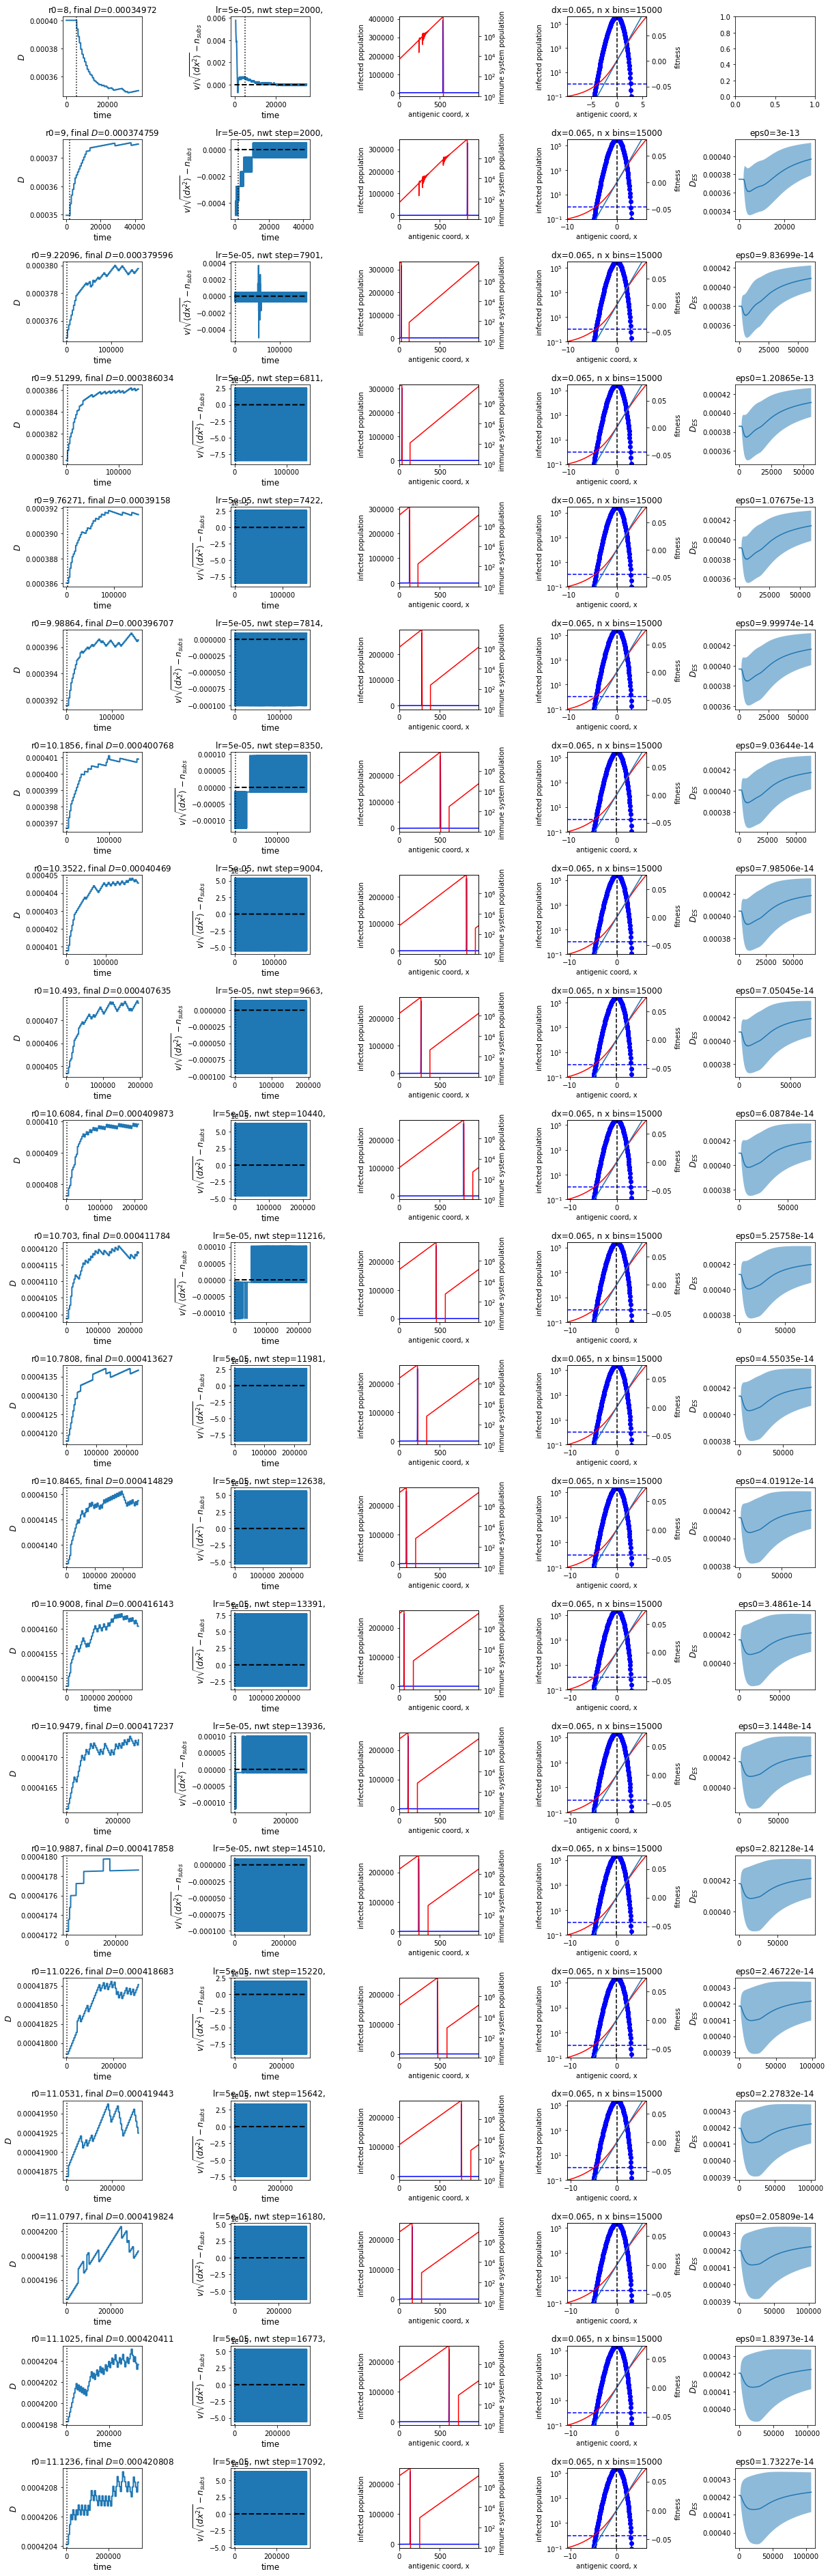

In [46]:
fig, axs = plt.subplots(len(waves_nwt),5,figsize=(17,2.5*len(waves_nwt)))

for i, w in enumerate(waves_nwt):
    axs[i][0] = plot_D_newton(axs[i][0], w)
    axs[i][1] = plot_loss_newton(axs[i][1], w)
    axs[i][2], axs[i][3] = plot_wave(axs[i][2], axs[i][3], w)
    if i>0:
        axs[i][4] = plot_D_es(axs[i][4], waves_es[i-1])
    
    plt.tight_layout()

To save memory, only the last pair of newton and ES waves are saved in a binary

In [47]:
f = open('data/final_wave_Ud=%g_Nh=%g.pickle'%(Ud, Nh), 'wb')
pickle.dump((waves_nwt[-1], waves_es[-1]), f)
f.close()

### Processing all the exported results for different deleterious mutation coefs

In [8]:
Uds, r0s, Dstars, Nhs = [], [], [], []

data_dir = 'data/'
for f_name in os.listdir(data_dir):
    if f_name.split('.')[-1] == 'pickle':
        Ud = float(f_name.split('_')[2].split('=')[1])
        f = open(data_dir+f_name, 'rb')
        w_nwt, w_es = pickle.load(f)
        f.close()
        Nh, Ds, r0 = w_nwt.p.Nh, w_es.traj.mean_D[-1], w_nwt.p.r0
        
        if Nh not in Nhs:
            Nhs.append(Nh)
            Uds.append(np.array([Ud]))
            Dstars.append(np.array([Ds]))
            r0s.append(np.array([r0]))
        else:
            Nh_index = Nhs.index(Nh)
            Uds[Nh_index] = np.append(Uds[Nh_index], Ud)
            Dstars[Nh_index] = np.append(Dstars[Nh_index], Ds)
            r0s[Nh_index] = np.append(r0s[Nh_index], r0)
            
for i in range(len(Nhs)):
    Ud_sorted_index = np.argsort(Uds[i])
    Uds[i] = Uds[i][Ud_sorted_index]
    Dstars[i] = Dstars[i][Ud_sorted_index]
    r0s[i] = r0s[i][Ud_sorted_index]

In [16]:
f = open('data/params.tsv', 'w')

header = '#Nh\tUd\tr0\tD\n'
f.write(header)

for i in range(len(Nhs)):
    for j in range(len(Uds[0])):
        f.write(str(Nhs[i]) + '\t')
        f.write(str(Uds[i][j]) + '\t')
        f.write(str(r0s[i][j]) + '\t')
        f.write(str(Dstars[i][j]) + '\t')
        f.write('\n')
    
f.close()